# Fold first, ask later: structure-informed function annotation of *Pseudomonas* phage proteins
## Pipeline stage 1: dataset creation

### Stage 1.1: input proteins - sequence level information

**Goals:**
* Extract all unique phages from the virus-host database overview file.
* Fetch protein information from NCBI protein for all these phages.
* Create overview & analyze taxonomy of these phages and their hosts.
* Summarize the NCBI protein data for these phages.

**Requires:**
*  virushostdb_host_pseudomonas_25feb2024.tsv stored in associated_data

**Generates (in folder a_input):**
* phage_data.tsv : a phage-centric overview of the virus & host taxonomic information from virushostdb_host_pseudomonas_25feb2024.tsv
* host_taxonomy_aggregated.tsv : overview of the different hosts and how many phages they are targeted by, extracted from virushostdb_host_pseudomonas_25feb2024.tsv
* in folder protein_overview:
    * PHAGE_protein_overview.txt : a tab-seperated overview of the NCBI proteins for each PHAGE, listing NCBI unique ID, NCBI protein name and protein length, with each row representing one NCBI protein entry
    * protein_overview.txt : aggregated overview of the NCBI proteins for all phages, formatted as PHAGE_protein_overview.txt

#### General settings, imports, variables and environments

Conda environment: ffal_input

Created with `conda create -n ffal_input`.
Then installed `jupyter notebook`, `pandas` through conda & `more_iterools`, `seaborn`, `scipy` through pip (command below).

In [ ]:
!pip install more-itertools

In [ ]:
!pip install seaborn

In [ ]:
!pip install scipy

In [1]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: win-64
# created-by: conda 24.11.3
@EXPLICIT
https://conda.anaconda.org/conda-forge/noarch/ca-certificates-2025.6.15-h4c7d964_0.conda
https://conda.anaconda.org/conda-forge/win-64/intel-openmp-2024.2.1-h57928b3_1083.conda
https://conda.anaconda.org/conda-forge/noarch/python_abi-3.13-7_cp313.conda
https://conda.anaconda.org/conda-forge/noarch/tzdata-2025b-h78e105d_0.conda
https://conda.anaconda.org/conda-forge/win-64/ucrt-10.0.22621.0-h57928b3_1.conda
https://conda.anaconda.org/conda-forge/win-64/winpty-0.4.3-4.tar.bz2
https://conda.anaconda.org/conda-forge/win-64/libwinpthread-12.0.0.r4.gg4f2fc60ca-h57928b3_9.conda
https://conda.anaconda.org/conda-forge/win-64/vc14_runtime-14.42.34438-hfd919c2_26.conda
https://conda.anaconda.org/conda-forge/win-64/vc-14.3-h2b53caa_26.conda
https://conda.anaconda.org/conda-forge/win-64/vs2015_runtime-14.42.34438-h7142326_26.conda
https://

In [52]:
# imports
import json
import os
import requests
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from io import StringIO
from more_itertools import batched
from scipy.stats import pearsonr, mannwhitneyu

In [3]:
# settings for requests
sess = requests.Session()
adapter = requests.adapters.HTTPAdapter(max_retries = 10)
sess.mount("https://", adapter)

In [4]:
# clear reference to different directories
pipeline_search_dir = os.getcwd()
master_dir = os.path.abspath(os.path.join(pipeline_search_dir, os.pardir, os.pardir))

In [ ]:
# creating a directory for all the data we will generate
os.mkdir(os.path.join(pipeline_search_dir, "a_input"))

#### Goal 1: extract all unique phages from the virus-host database overview file

The overview downloaded from the virus host database contains 1 line per virus-host pair, meaning that phages with multiple hosts are represented multiple times. Here, we create a non-redundant overview of the different phages.

In [5]:
virushost_data = pd.read_table(os.path.join(master_dir, "associated_data", "virushostdb_host_pseudomonas_25feb2024.tsv"))

In [6]:
# creating phage centered table
phage_data = virushost_data[["virus tax id", "virus name", "virus lineage"]]
phage_data = phage_data.drop_duplicates()
phage_data = phage_data.reset_index(drop = True)
phage_data["taxid_name"] = phage_data["virus tax id"].astype(str) + "_" + phage_data["virus name"].str.split().str[-1]
# adding aggregated host data
agg_host_data = virushost_data.groupby(["virus tax id", "virus name"], as_index=False).agg({"host name": list, "host lineage" : list})
phage_data = phage_data.merge(agg_host_data)

#### Goal 2: fetch protein information from NCBI protein for all these phages

To fetch protein information, we will create a list of all phages in our dataset. 

In [7]:
# generating a list of our phages
phages = list(phage_data["taxid_name"]) #sadly some phage names are computationally challenging, containing / or . 
# we will replace / by SLASH, . by DOT
for index, phage in enumerate(phages):
    if "." in phage:
        phages[index] = phage.replace(".","DOT")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace(".","DOT")
    if "/" in phage:
        phages[index] = phage.replace("/","SLASH")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("/","SLASH")
    # we also deal with some unrecognizable naming
    if "2979339" in phage:
        phages[index] = phage.replace("_10","_Wadjak_10")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_10","_Wadjak_10")
    if "2979340" in phage:
        phages[index] = phage.replace("_11","_Wadjak_11")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_11","_Wadjak_11")
    if "2979341" in phage:
        phages[index] = phage.replace("_12","_Wadjak_12")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_12","_Wadjak_12")
    if "2979342" in phage:
        phages[index] = phage.replace("_13","_Wadjak_13")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_13","_Wadjak_13")
    if "2979343" in phage:
        phages[index] = phage.replace("_14","_Wadjak_14")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_14","_Wadjak_14")
    if "2979344" in phage:
        phages[index] = phage.replace("_15","_Wadjak_15")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_15","_Wadjak_15")
    if "2979345" in phage:
        phages[index] = phage.replace("_16","_Wadjak_16")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_16","_Wadjak_16")
    if "2979346" in phage:
        phages[index] = phage.replace("_4","_Wadjak_4")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_4","_Wadjak_4")
    if "2979347" in phage:
        phages[index] = phage.replace("_5","_Wadjak_5")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_5","_Wadjak_5")
    if "2979348" in phage:
        phages[index] = phage.replace("_6","_Wadjak_6")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_6","_Wadjak_6")
    if "2979349" in phage:
        phages[index] = phage.replace("_7","_Wadjak_7")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_7","_Wadjak_7")
    if "2979350" in phage:
        phages[index] = phage.replace("_8","_Wadjak_8")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_8","_Wadjak_8")
    if "2979351" in phage:
        phages[index] = phage.replace("_9","_Wadjak_9")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_9","_Wadjak_9")
    if "2979352" in phage:
        phages[index] = phage.replace("_1","_Wadjak_1")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_1","_Wadjak_1")
    if "2979353" in phage:
        phages[index] = phage.replace("_2","_Wadjak_2")
        phage_data.loc[index,"taxid_name"] = phage_data.loc[index,"taxid_name"].replace("_2","_Wadjak_2")

Then, we can use eutils to obtain a summary of the proteins for all our phages. *This was executed in March '24, and not repeated here*.

In [ ]:
# creating a directory for all the data we will generate
os.mkdir(os.path.join(pipeline_search_dir, "a_input", "protein_overview"))

In [ ]:
# the URLs
url_overview = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=protein&term=txid{0}&retmax=1000&retmode=json"
url_proteins = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=protein&id={0}&retmax=1000&retmode=json"
# We create 1 file with all proteins, and then a file per phage
f_all_phages = open(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "protein_overview.txt"), "w")
for phage in phages:
    taxid = phage.split("_")[0]
    phage_protein_ids = sess.get(url_overview.format(taxid), stream=True).text
    data_ids = json.loads(phage_protein_ids)
    # check if any proteins present for this phage
    if len(data_ids.get("esearchresult").get("idlist")) != 0:
        f_per_phage = open(os.path.join(pipeline_search_dir, "a_input", "protein_overview", f"{phage}_protein_overview.txt"), "w")
        # batching to circumvent too long URLs
        for batch in batched(data_ids.get("esearchresult").get("idlist"), 100):
            phage_protein_ids_string = ",".join(batch)
            response = sess.get(url_proteins.format(phage_protein_ids_string), stream=True)
            response.raise_for_status()
            phage_protein_overview = response.text
            data = json.loads(phage_protein_overview)
            ids = data.get("result").get("uids")
            for id in ids:
                name = data.get("result").get(id).get("title")
                length = data.get("result").get(id).get("slen")
                f_per_phage.write(f"{id}\t{name}\t{length}\n")
                f_all_phages.write(f"{phage}\t{id}\t{name}\t{length}\n")
        f_per_phage.close()
f_all_phages.close()

In [8]:
# remove phages with no proteins in NCBI protein from our list
protein_data = pd.read_table(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "protein_overview.txt"), names=["taxid_name", "ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"])
removed = []
# find missing phages
for phage in phages:
    if phage not in protein_data["taxid_name"].unique():
        removed.append(phage)
# remove from list
for item in removed:
    phages.remove(item)
# print out number of removed phages
num_removed = len(removed)
print(f"Removed {num_removed} phages from the dataset, as they did not have any NCBI protein entries.")
# effectively remove them from the dataset
phage_data = phage_data[phage_data["taxid_name"].isin(phages)]
phage_data = phage_data.reset_index(drop = True)

Removed 73 phages from the dataset, as they did not have any NCBI protein entries.


In [ ]:
# store overview of phages 
phage_data.to_csv(os.path.join(pipeline_search_dir, "a_input", "phage_data.tsv"), sep="\t", index=False)

#### Goal 3: create overview & analyze taxonomy of these phages and their hosts

In achieving goals 1 & 2, we have created an overview of the different hosts and phages in a phage-centric manner. Now, we will summarize this data to better grasp its contents, and gain understanding into the phage in our dataset. 

First, we will summarize the **virus taxonomy**. This is not straightforward, as not all taxonomy levels are necessarily filled (e.g.: jumping from class to subfamily, omitting order and family). Brielfy, the column 'virus_lineage' was extracted from the file `phage_data.tsv` (stored in file `phage_lineage.txt` in folder `article_figures/fig1/subplotA`), and manually corrected using the ICTV taxonomy (stored in file `phage_data_correctTaxLevels.txt` in folder `article_figures/fig1/subplotA`). This data was then manipulated using R to generate a Sankey plot (with Pavian) summarizing the viral taxonomy. In conclusion: 98% of all phages are dsDNA phages, which are all Caudoviricites. There are 10 riboviriae, representing 1% of all data; 5 monodnaviriae; 1 varidnaviriae and 2 unclassified bacterial viruses. Of the dsDNA phages, 18% falls under Pubnaviruses and 16% Autographviridae; no other groups (except unclassified Caudoviricites at 17%) exceed 10%. 

Next, we look into the **host distribution**. We create an overview of the different hosts and how abundant they are amongst our phages by aggregating the data by the host name.

In [9]:
phage_data["host name string"] = [",".join(map(str, host)) for host in phage_data["host name"]]
phage_data["host lineage string"] = [",".join(map(str, host)) for host in phage_data["host lineage"]]
host_data = phage_data.groupby(["host name string","host lineage string"], as_index = False).size() 
host_data # issue: some host are described both by species and strain/pv. --> manually remove more general one for statistics

,host name string,host lineage string,size
0,"Escherichia coli,Pseudomonas aeruginosa PAO1",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
1,Pseudomonas,Bacteria; Pseudomonadota; Gammaproteobacteria;...,73
2,Pseudomonas aeruginosa,Bacteria; Pseudomonadota; Gammaproteobacteria;...,413
3,Pseudomonas aeruginosa ATCC 15442,Bacteria; Pseudomonadota; Gammaproteobacteria;...,2
4,Pseudomonas aeruginosa CHA,Bacteria; Pseudomonadota; Gammaproteobacteria;...,2
...,...,...,...
62,Pseudomonas tolaasii NCPPB 2192,Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
63,"Pseudomonas,Pseudomonas aeruginosa",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
64,"Pseudomonas,Pseudomonas aeruginosa PA14",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
65,"Pseudomonas,Pseudomonas aeruginosa PAO1",Bacteria; Pseudomonadota; Gammaproteobacteria;...,2


In [10]:
host_data.to_csv("hostdataforfig.tsv", sep = "\t")

In [10]:
# manually remove more general one for statistics
phage_data = phage_data.replace("Pseudomonas aeruginosa,Pseudomonas aeruginosa CF127", "Pseudomonas aeruginosa CF127")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas aeruginosa,Pseudomonas aeruginosa CF5", "Pseudomonas aeruginosa CF5")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas aeruginosa,Pseudomonas aeruginosa CF77", "Pseudomonas aeruginosa CF77")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas aeruginosa,Pseudomonas aeruginosa PAO1", "Pseudomonas aeruginosa PAO1")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas aeruginosa,Pseudomonas aeruginosa PAO1,Pseudomonas aeruginosa ATCC 15442", "Pseudomonas aeruginosa PAO1,Pseudomonas aeruginosa ATCC 15442")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas sp.,Pseudomonas aeruginosa PAO1", "Pseudomonas aeruginosa PAO1")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas syringae,Pseudomonas syringae pv. actinidiae", "Pseudomonas syringae pv. actinidiae")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1")
phage_data = phage_data.replace("Pseudomonas syringae,Pseudomonas syringae pv. tomato", "Pseudomonas syringae pv. tomato")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group")
phage_data = phage_data.replace("Pseudomonas,Pseudomonas aeruginosa", "Pseudomonas aeruginosa")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group")
phage_data = phage_data.replace("Pseudomonas,Pseudomonas aeruginosa PA14", "Pseudomonas aeruginosa PA14")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas,Pseudomonas aeruginosa PAO1", "Pseudomonas aeruginosa PAO1")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group; Pseudomonas aeruginosa")
phage_data = phage_data.replace("Pseudomonas,Pseudomonas syringae pv. actinidiae", "Pseudomonas syringae pv. actinidiae")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1")
phage_data = phage_data.replace("Pseudomonas aeruginosa,Pseudomonas sp.", "Pseudomonas aeruginosa")
phage_data = phage_data.replace("Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas","Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas aeruginosa group")
# manually fix one issue after these replacements (removed too much since lineage occured twice, also once where it was justified)
phage_data.at[0, "host lineage string"] = "Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 1,Bacteria; Pseudomonadota; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group"
# regroup with new names
host_data = phage_data.groupby(["host name string", "host lineage string"], as_index = False).size() 
host_data

,host name string,host lineage string,size
0,"Escherichia coli,Pseudomonas aeruginosa PAO1",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
1,Pseudomonas,Bacteria; Pseudomonadota; Gammaproteobacteria;...,73
2,Pseudomonas aeruginosa,Bacteria; Pseudomonadota; Gammaproteobacteria;...,415
3,Pseudomonas aeruginosa ATCC 15442,Bacteria; Pseudomonadota; Gammaproteobacteria;...,2
4,Pseudomonas aeruginosa CF127,Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
5,Pseudomonas aeruginosa CF5,Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
6,Pseudomonas aeruginosa CF77,Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
7,Pseudomonas aeruginosa CHA,Bacteria; Pseudomonadota; Gammaproteobacteria;...,2
8,Pseudomonas aeruginosa DSM 50071 = NBRC 12689,Bacteria; Pseudomonadota; Gammaproteobacteria;...,2
9,Pseudomonas aeruginosa PA1,Bacteria; Pseudomonadota; Gammaproteobacteria;...,3


In [11]:
# Some statistics
    # number of phages with more than 1 host 
num_multiple_host = host_data[host_data["host name string"].str.contains(r",")]["size"].sum()
    # number of phages with just 1 host 
num_one_host = host_data["size"].sum() - num_multiple_host
    # of those with multiple hosts, number with species diversity
multiple_host_names = list(host_data[host_data["host name string"].str.contains(r",")]["host name string"])
multiple_host_multiple_species = []
for hostset in multiple_host_names:
    list_hosts = hostset.split(",")
    species_set = set()
    for host in list_hosts:
        species = host.split()
        species_set.add(species[0])
    if len(species_set) > 1:
        multiple_host_multiple_species.append(hostset)
subset_multiple_hosts = host_data["host name string"].isin(multiple_host_multiple_species)
num_multiple_host_multiple_species = host_data[subset_multiple_hosts]["size"].sum()
    # of those with multiple hosts, number with strain diversity
num_multiple_host_within_species = num_multiple_host - num_multiple_host_multiple_species
# print results
print("Overview host taxonomy statistics:")
print("Phages with only 1 host: ", num_one_host)
print("Phages with more than 1 host: ", num_multiple_host)
print("Of those with multiple hosts...")
print("\t", num_multiple_host_multiple_species, "phages have multiple hosts that are from different species.")
print("\t", num_multiple_host_within_species, "phages have multiple hosts that are from the same species.")

Overview host taxonomy statistics:
Phages with only 1 host:  874
Phages with more than 1 host:  13
Of those with multiple hosts...
	 6 phages have multiple hosts that are from different species.
	 7 phages have multiple hosts that are from the same species.


To look into the host taxonomy, we again use a Sankey plot. To make this overview biologically sensible, we weigh the different taxonomies by the amount of phages they were found in (so total: 887, like the virus taxonomy analysis). In order to not exceed the total number of phages, phages for which multiple hosts are reported are split proportionally across these different hosts. 

In [12]:
# getting an overview of the names of phages with more than 1 hosts
host_data[host_data["host name string"].str.contains(r",")]

,host name string,host lineage string,size
0,"Escherichia coli,Pseudomonas aeruginosa PAO1",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
13,"Pseudomonas aeruginosa PAO1,Pseudomonas aerugi...",Bacteria; Pseudomonadota; Gammaproteobacteria;...,2
15,"Pseudomonas aeruginosa,Pseudomonas fluorescens...",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
16,"Pseudomonas aeruginosa,Pseudomonas syringae,Es...",Bacteria; Pseudomonadota; Gammaproteobacteria;...,4
27,"Pseudomonas fluorescens,Pseudomonas putida",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
31,"Pseudomonas lactis,Pseudomonas carnis",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
42,"Pseudomonas savastanoi pv. phaseolicola,Pseudo...",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
47,"Pseudomonas sp. D3,Pseudomonas sp. G11",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1
53,"Pseudomonas syringae pv. syringae,Pseudomonas ...",Bacteria; Pseudomonadota; Gammaproteobacteria;...,1


In [ ]:
# storing the phage data to extract the lineages
host_data.to_csv(os.path.join(pipeline_search_dir, "a_input", "host_taxonomy_aggregated.tsv"))

After manually splitting up phages with multiple hosts proportionally, the host lineage information was manually edited to (i) include the host name string , and (ii) be consistent in taxonomy levels used (final result stored in file `host_lineage_correctedCounts_lineageFormatted.txt` in folder `article_figures/fig1/subplotB`). This data was then manipulated using R to generate a Sankey plot (with Pavian) summarizing the host taxonomy. In conclusion: 65% of phages have *P. aeruginosa* as host, 8% *P. syringae*, 3% *P. fluorescens* and  2% *P. putida*. The majority of the other phages have a host described as *Pseudomonas*, without further detail.

#### Goal 4: summarize the NCBI protein data for these phages

Let's summarize the NCBI protein dataset for these phages, to get a grasp on the data in there. Let's first look at the **distribution of (un)annotated proteins**:

In [13]:
# list of phages for which did not fit the 'hypothetical protein'/'phage protein' description for unannotated proteins
    # this knowledge is based on the fetching of unannotated proteins for structure prediction in the next notebook
phage_exceptions = ["161736_phi12", "593131_phi2954", "2905945_phiKZ"]
# empty dataframes to be filled
unannotated_entries = pd.DataFrame()
annotated_entries = pd.DataFrame()
# dictionary to store unannotated fraction & total number of entries
unannPer_totEnt = {}
# splitting
for phage in phages:
    protein_per_phage = pd.read_csv(os.path.join(pipeline_search_dir, "a_input", "protein_overview", f"{phage}_protein_overview.txt"), names=["ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"], sep="\t")
    if phage not in phage_exceptions: 
        unannotated_per_phage = protein_per_phage[(protein_per_phage["ncbi_protein_name"].str.contains("hypothetical protein", case=False)) | (protein_per_phage["ncbi_protein_name"].str.contains("phage protein", case=False))]
        annotated_per_phage = protein_per_phage[~((protein_per_phage["ncbi_protein_name"].str.contains("hypothetical protein", case=False)) | (protein_per_phage["ncbi_protein_name"].str.contains("phage protein", case=False)))]
        unannotated_entries = pd.concat([unannotated_per_phage, unannotated_entries], ignore_index = True)
        annotated_entries = pd.concat([annotated_per_phage, annotated_entries], ignore_index = True)
        unannPer_totEnt[phage] = ((len(unannotated_per_phage)/len(protein_per_phage)*100), len(protein_per_phage))
    if phage in phage_exceptions:
        if phage == "161736_phi12":
            ids_phi12 = [22855226, 22855212, 22855211, 15488105, 15488104]
            unannotated_phi12 = protein_per_phage[protein_per_phage["ncbi_protein_id"].isin(ids_phi12)].reset_index(drop = True)
            annotated_phi12 = protein_per_phage[~(protein_per_phage["ncbi_protein_id"].isin(ids_phi12))].reset_index(drop = True)
            unannotated_entries = pd.concat([unannotated_phi12, unannotated_entries], ignore_index = True)
            annotated_entries = pd.concat([annotated_phi12, annotated_entries], ignore_index = True)
            unannPer_totEnt[phage] = ((len(unannotated_phi12)/len(protein_per_phage)*100), len(protein_per_phage))
        if phage == "593131_phi2954":
            unannotated_entries = pd.concat([protein_per_phage, unannotated_entries], ignore_index = True)
            unannPer_totEnt[phage] = ((len(protein_per_phage)/len(protein_per_phage)*100), len(protein_per_phage))
        if phage == "2905945_phiKZ":
            entries_phikz = protein_per_phage
            entries_phikz[["protein_name_split", "species"]] = entries_phikz["ncbi_protein_name"].str.split("[",expand=True)
            unannotated_phikz = entries_phikz[(entries_phikz["species"].str.contains("Pseudomonas phage phiKZ]")) & (entries_phikz["protein_name_split"].str.contains("PhiKZ", case = False))].reset_index(drop = True)  
            annotated_phikz = entries_phikz[~((entries_phikz["species"].str.contains("Pseudomonas phage phiKZ]")) & (entries_phikz["protein_name_split"].str.contains("PhiKZ", case = False)))].reset_index(drop = True)
            unannotated_entries = pd.concat([unannotated_phikz, unannotated_entries], ignore_index = True)
            annotated_entries = pd.concat([annotated_phikz, annotated_entries], ignore_index = True)
            unannPer_totEnt[phage] = ((len(unannotated_phikz)/len(protein_per_phage)*100), len(protein_per_phage))

In [14]:
# summary statement on (un)annotated percentage of dataset
print(f"Out of {len(protein_data)} NCBI protein entries, {len(annotated_entries)} are annotated, leaving {len(unannotated_entries)} unannotated.")
percent_un = "{:.2f}".format(len(unannotated_entries)/len(protein_data)*100)
print(f"This means {percent_un}% of the NCBI proteins are unannotated.")

Out of 121654 NCBI protein entries, 35028 are annotated, leaving 86626 unannotated.
This means 71.21% of the NCBI proteins are unannotated.


Let's have a look at whether this 71% is consistent across phages, and whether it depends on the number of NCBI proteins fetched for a phage:

In [14]:
# looking into the relationship between number of proteins and unannotated fraction - numerically
df_uap = pd.DataFrame.from_dict(unannPer_totEnt, orient='index').reset_index()
df_uap.rename(columns = {"index": "phage", 0:"percentage_unannotated", 1: "total_entries"}, inplace = True)
print("The average phage contains", "{:.2f}".format(np.mean(df_uap["percentage_unannotated"])), "+-", "{:.2f}".format(np.std(df_uap["percentage_unannotated"])), "% unannotated protein entries.")

The average phage contains 67.10 +- 18.41 % unannotated protein entries.


In [15]:
# let's check whether there is a significant correlation between the number of proteins and the unannotated portion
pearsonr(df_uap["percentage_unannotated"], df_uap["total_entries"])

PearsonRResult(statistic=np.float64(0.24248174158856778), pvalue=np.float64(2.4599979746829246e-13))

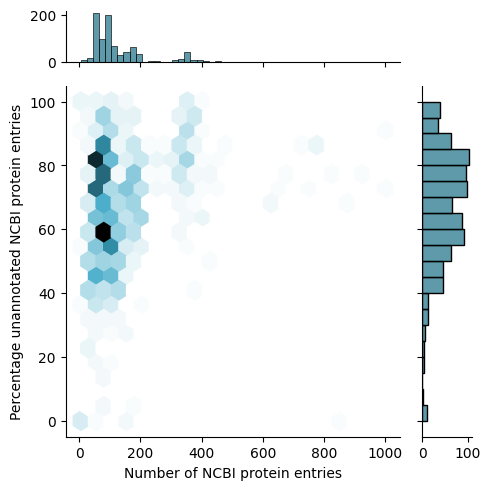

In [26]:
plot = sns.jointplot(df_uap, x = "total_entries", y = "percentage_unannotated", kind = "hex", gridsize = 20, height = 5, ratio = 5, color = "#2a788e", palette = ["#2a788e"], marginal_ticks = True)
plot.set_axis_labels("Number of NCBI protein entries", "Percentage unannotated NCBI protein entries", fontsize=10)
plot.figure.tight_layout() 
plot.savefig(os.path.join(master_dir, "article_figures", "fig1", "jointplot_num_unann_num_tot.svg"), format = "svg", transparent = True)

Let's now look at the **protein size distribution**, and test the hypothesis that shorter proteins are harder to annotate:

In [27]:
# let's add a label to the protein data dataframe depicting the annotation status
protein_data.loc[protein_data["ncbi_protein_id"].isin(list(unannotated_entries["ncbi_protein_id"])), "label"] = "unannotated"
protein_data.loc[protein_data["ncbi_protein_id"].isin(list(annotated_entries["ncbi_protein_id"])), "label"] = "annotated"
protein_data

,taxid_name,ncbi_protein_id,ncbi_protein_name,ncbi_protein_length,label
0,2662138_Phobos,1985465487,hypothetical protein JT319_gp63 [Bacteriophage...,59,unannotated
1,2662138_Phobos,1985465486,hypothetical protein JT319_gp62 [Bacteriophage...,383,unannotated
2,2662138_Phobos,1985465485,hypothetical protein JT319_gp61 [Bacteriophage...,43,unannotated
3,2662138_Phobos,1985465484,hypothetical protein JT319_gp60 [Bacteriophage...,138,unannotated
4,2662138_Phobos,1985465483,hypothetical protein JT319_gp59 [Bacteriophage...,257,unannotated
...,...,...,...,...,...
121649,2848094_LeviOr01,2046361479,putative coat protein [ssRNA phage LeviOr01],129,annotated
121650,2848094_LeviOr01,2046361478,putative maturation protein [ssRNA phage LeviO...,463,annotated
121651,2848094_LeviOr01,1160578521,putative RNA replicase [ssRNA phage LeviOr01],544,annotated
121652,2848094_LeviOr01,1160578520,putative coat protein [ssRNA phage LeviOr01],129,annotated


In [28]:
# let's look at it numerically
print("The average annotated phage protein entry is", "{:.0f}".format(np.mean(annotated_entries["ncbi_protein_length"])), "+-", "{:.0f}".format(np.std(annotated_entries["ncbi_protein_length"])), "AA.")
print("The average unannotated phage protein entry is", "{:.0f}".format(np.mean(unannotated_entries["ncbi_protein_length"])), "+-", "{:.0f}".format(np.std(unannotated_entries["ncbi_protein_length"])), "AA.")

The average annotated phage protein entry is 343 +- 288 AA.
The average unannotated phage protein entry is 159 +- 166 AA.


In [56]:
# let's test whether they are significantly different with a Mann Whitney U test
mannwhitneyu(unannotated_entries["ncbi_protein_length"], annotated_entries["ncbi_protein_length"], alternative = "less")

MannwhitneyuResult(statistic=np.float64(660187888.0), pvalue=np.float64(0.0))

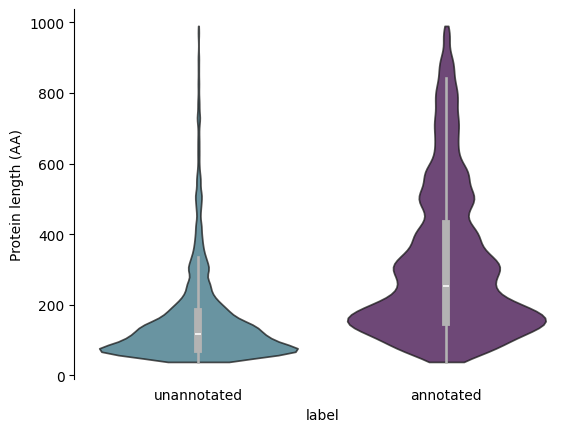

In [55]:
# let's now plot size for all proteins, seperating annotated from unannotated proteins
vplot = sns.violinplot(data = protein_data[protein_data["ncbi_protein_length"].between(protein_data["ncbi_protein_length"].quantile(0.01), protein_data["ncbi_protein_length"].quantile(.99))],
                       x = "label", y = "ncbi_protein_length", hue = "label", legend = False, palette = ["#2a788e", "#440154"], cut = 0, 
                       inner_kws=dict(color=".7"), alpha = 0.75)
sns.despine(top = True, bottom = True, right = True)
vplot.set_ylabel("Protein length (AA)")
vplot.tick_params(bottom=False) 
plt.savefig(os.path.join(master_dir, "article_figures", "fig1", "violinplot_ann_unann_length.svg"), format = "svg", transparent = True)